In [3]:
import shutil
from PIL import Image

In [6]:
# parse directory for file names
import os

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

In [41]:
# resize images
# read images into arrays

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean

image_width = 28
image_height = 28

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    image = imread(file)
    image_resized = resize(image, (image_width, image_height), anti_aliasing=True)
    dataset[i] = image_resized
    i += 1

In [42]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [48]:
# input = output because this is image reconstruction
x_train = np.reshape(dataset, (len(dataset), image_width, image_height, 1))
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1282
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1282
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1282
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1282
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1282
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1282
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1282
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1282
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1282
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1282
Epoch 11/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1282
Epoch 12/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1281
Epoch 13/50
5/5 [==============================] - 0s 4ms/step - loss: 0.

In [44]:
# predict image

In [35]:
def convert(dataset_path):
    data = []
    for _, _, files in os.walk(dataset_path):
        for filename in files:
            filepath = os.path.join(dataset_path, filename)
            px = skimage.io.imread(filepath)
            data.append(px)
    return data

In [18]:
full = mpimg.imread('../data/raw/test.tif')

(2048, 2048)

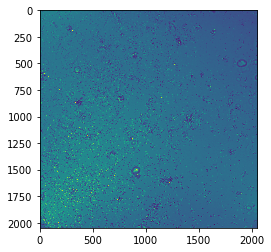

In [10]:
imgplot = plt.imshow(img)
img.shape

In [7]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

Using TensorFlow backend.


In [55]:
input_dim = x_train.shape[1] # 784
encoding_dim = 32

compression_factor = float(input_dim)/encoding_dim

In [59]:
x_train = x_train.reshape((len(x_train), 16, 16, 1))

ValueError: cannot reshape array of size 983040 into shape (5,16,16,1)

In [98]:
cnn_autoencoder = Sequential()

In [99]:
# Encoder Layers
cnn_autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
cnn_autoencoder.add(MaxPooling2D((2, 2), padding='same'))
cnn_autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
cnn_autoencoder.add(MaxPooling2D((2, 2), padding='same'))
cnn_autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

In [100]:
# Flatten encoding for visualisation
cnn_autoencoder.add(Flatten())
cnn_autoencoder.add(Reshape((4, 4, 8)))

ValueError: total size of new array must be unchanged